In [19]:
from __future__ import print_function

import argparse
import sys
import os

import random

import time
import datetime

from collections import Counter
import numpy as np

import shutil
import inspect

import gc

import re

import keras
from keras import models
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K

import tensorflow as tf

from IPython.display import display
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix



### Data Visualization Function

In [20]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    
def reset_plot_propert(plot_property=None):
    plot_property = {
        'figsize':(15, 5),
        'title':'title',
        'xlabel': None,
        'ylabel': None,
        'legend': None,
        'title_fontsize' : 18,
        'label_fontsize':14, 
        'subplot':None}
    return plot_property

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x=dir_name
    y=dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title +" (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title +" (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title +" (Testing)"
    plot_property['subplot'] = subplot_no+2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [21]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory+ r"train"
validation_dir = input_directory+ r"val"
testing_dir = input_directory+ r"test"

### Data Visualization

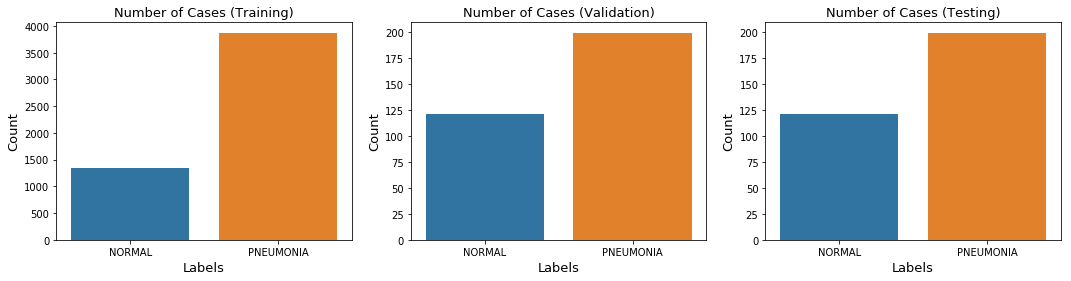

In [22]:
plot_property = reset_plot_propert(plot_property=None)

plot_property['figsize'] = (18,4)

plot_property['title_fontsize']=13
plot_property['label_fontsize']=13

plot_property['title'] = "Number of Cases"

plot_property['xlabel']="Labels"
plot_property['ylabel']="Count"

plot_property['subplot']=131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_property)


### Tensorflow Graph Function

In [23]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    try:
        del model
    except:
        return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint=None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

In [24]:
reset_graph(model)

NameError: name 'model' is not defined

## Preprocessing (Image Preprocessing)

#### Configuring Image Transformation Parameters for Training, Validation, Testing and  Dataset 

In [27]:


# Image normalization
#----------------------#
norm=255.0

# recscaling
#----------------------#
rescale=1./norm



### Image Transformation for Training, Validation, Testing and  Dataset 

In [28]:
rescale = 1./255


target_size = (299,299)
batch_size = 32

class_mode = 'categorical'



train_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode)



test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


#### Weight Adjustment for Class Label Imbalance

##  Training Configuration
### Setting Output Directory (Model and Log) 

In [30]:
#--------------------------------------------------------------------------------------------------------------------#
# Model Directory
#--------------------------------------------------------------------------------------------------------------------#
model_dir=output_directory + r"models/"+time.strftime('%Y-%m-%d %H-%M-%S')+"/"
#--------------------------------------------------------------------------------------------------------------------#
# Log Directory
#--------------------------------------------------------------------------------------------------------------------#
log_dir=output_directory + r"logs/"+time.strftime('%Y-%m-%d %H-%M-%S')
#--------------------------------------------------------------------------------------------------------------------#



# Create Output Directory (Model and Log)
#--------------------------------------------------------------------------------------------------------------------#
create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)
#--------------------------------------------------------------------------------------------------------------------#


#--------------------------------------------------------------------------------------------------------------------#
# Model File Name Configuration
#------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Initial Trainning Model Filename 
#----------------------------------------------------------------------------------------------------#
init_model_file=model_dir+"base-"+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Trainning Model Filename 
#----------------------------------------------------------------------------------------------------#
model_file=model_dir+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Retrainning Model Filename 
#----------------------------------------------------------------------------------------------------#
retrain_model_file=model_dir+"retrain-{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

NameError: name 'create_directory' is not defined

In [ ]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_loss',
    save_best_only=True, 
    save_weights_only=False)


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=0)

In [ ]:
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, early_stopping, tensorboard]


In [17]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_inception_model():    
    
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.5)(x)
    
    x = Dense(1024, activation='relu')(x)
    
    x = Dense(2, activation='softmax')(x) 
    predictions = BatchNormalization()(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True
        
    
    model.summary()
        
    return model



In [18]:
## Training Base Model

# get inception model
date_time(1)

model = get_inception_model()

main_model = model

date_time(1)

NameError: name 'date_time' is not defined